# AutoEncoder with Feature Integration (from FeatureIntegration.ipynb)

In [1]:
selected_feature = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

## Environment

In [2]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
def seed_everything(seed=302):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
seed_everything()

## Data & Hyperparameter

In [6]:
train_df = pd.read_csv('data/train.csv') # 정상, 사기 거래의 여부를 알 수 없는(대부분 정상 거래) 신용 카드 데이터 (Unlabeled)
val_df = pd.read_csv('data/val.csv') # 정상, 사기 거래의 여부가 포함된 신용 카드 데이터 (학습 불가능)
test_df = pd.read_csv('data/test.csv') # 정상, 사기 거래의 여부를 알 수 없는(대부분 정상 거래) 신용 카드 데이터 (Unlabeled)
sample_submission = pd.read_csv('data/sample_submission.csv') # 정상:0, 사기:1

In [7]:
train_df = train_df[selected_feature]
val_df = val_df[selected_feature + ['Class']]
test_df = test_df[selected_feature]
train_df.shape, val_df.shape, test_df.shape

((113842, 15), (28462, 16), (142503, 15))

In [8]:
display(train_df.head(), 
        val_df.head(), 
        test_df.head())

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,-0.568671,-0.371407,1.341262,0.359894,-0.137134,0.401726,-0.058133,0.068653
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,0.615375,1.249376,-0.619468,0.291474,-1.323865,-0.076127,-1.222127,-0.358222
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,-0.392048,-0.410430,-0.705117,-0.110452,0.074355,-0.210077,-0.499768,0.118765


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,-0.736727,-0.366846,1.017614,0.836390,-0.443523,0.739453,-0.540980,0.476677,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,-1.191311,0.724396,1.690330,0.406774,0.983739,-0.602232,0.402484,-1.737162,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.896287,0.757952,-0.448937,-0.660863,0.788864,0.295404,-0.287878,-0.451453,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.226278,-0.225495,1.944545,1.385160,0.314166,-1.333716,1.002869,-2.119314,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,4.009259,6.051521,2.572500,0.066851,-2.837136,-0.303774,-1.942303,-0.435450,0


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.464960,-0.099254,-1.416907,-0.153826,0.167372,-0.443587,0.002821,-0.611987
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,-0.558895,0.309755,-0.259116,-0.326143,0.362832,-0.129487,-0.809979,0.359985


In [9]:
class CustomDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
    
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            
            return torch.Tensor(self.x), self.y
        
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [10]:
# Train_df의 정상/사기 여부를 알 수 없기 때문에 작은 batch_size 적용 시 batch 안의 사기 데이터가 큰 영향을 끼칠 수 있다. 
# 따라서 상대적으로 큰 batch_size를 적용한다.
batch_size = 14231 

In [11]:
train_dataset = CustomDataset(train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = CustomDataset(val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = CustomDataset(test_df, eval_mode=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

## Model

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(15, 32), 
            nn.BatchNorm1d(32), 
            nn.LeakyReLU(),
            nn.Linear(32, 64), 
            nn.BatchNorm1d(64), 
            nn.LeakyReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(64, 32), 
            nn.BatchNorm1d(32), 
            nn.LeakyReLU(), 
            nn.Linear(32, 15)
        )
        
    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        
        return decoded

## Train & Evaluation

In [13]:
class Optimization:
    def __init__(self, model, optimizer, criterion, scheduler, device, threshold):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = device
        self.train_loss = list()
        self.THRESHOLD = threshold
        
    def proccess_one_batch(self, x):
        self.model.train()
        decoded = self.model(x)
        loss = self.criterion(x, decoded)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, train_loader, val_loader, epochs):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(epochs):
            batch_train_losses = list()
            for index, x in enumerate(train_loader):
                x = x.float().to(self.device)
                loss = self.proccess_one_batch(x)
                batch_train_losses.append(loss)
            current_training_loss = np.mean(batch_train_losses)
            self.train_loss.append(current_training_loss)
                
            with torch.no_grad():
                cos = nn.CosineSimilarity(dim=1, eps=1e-6)
                pred = list()
                true = list()
                for x, y in val_loader:
                    x = x.float().to(self.device)
                    self.model.eval()
                    decoded = self.model(x)
                    diff = cos(x, decoded).cpu().tolist()
                    batch_pred = np.where(np.array(diff)<self.THRESHOLD, 1, 0).tolist()
                    pred += batch_pred
                    true += y.tolist()
                
            score = f1_score(true, pred, average='macro')
            
            print('EPOCH [{}/{}]: Training Loss: {}, Validation Score: {}'.format(epoch+1, epochs, np.mean(self.train_loss), score))
            
            if self.scheduler is not None:
                self.scheduler.step(score)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(), 'checkpoint_AE/best_model.pth', _use_new_zipfile_serialization=False)
                print('MODEL SAVED')
        
        return self.train_loss
        
    def evaluate(self, test_loader):
        self.model.to(self.device)
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        pred = list()
        with torch.no_grad():
            for x in test_loader:
                x = x.float().to(self.device)
                self.model.eval()
                decoded = self.model(x)
                diff = cos(x, decoded).cpu().tolist()
                batch_pred = np.where(np.array(diff)<self.THRESHOLD, 1, 0).tolist()
                pred += batch_pred

        return pred

In [14]:
model = AutoEncoder()
learning_rate = 1e-2
epochs = 150
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# ReduceLROnPlateau reduce learning rate when a metric has stopped improving for 'patience' number of epochs by a factor of 'factor'.
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = nn.L1Loss()

In [15]:
opt = Optimization(model, optimizer, criterion, schedular, device, 0.95)
loss = opt.train(train_loader, val_loader, epochs)

EPOCH [1/150]: Training Loss: 0.6669925674796104, Validation Score: 0.008427329658014354
MODEL SAVED
EPOCH [2/150]: Training Loss: 0.5594908986240625, Validation Score: 0.19795682328493083
MODEL SAVED
EPOCH [3/150]: Training Loss: 0.48683192456762, Validation Score: 0.33715081028540733
MODEL SAVED
EPOCH [4/150]: Training Loss: 0.43304580450057983, Validation Score: 0.41608013272820993
MODEL SAVED
EPOCH [5/150]: Training Loss: 0.3913154825568199, Validation Score: 0.45271392181854725
MODEL SAVED
EPOCH [6/150]: Training Loss: 0.35821438673883677, Validation Score: 0.4816582226835856
MODEL SAVED
EPOCH [7/150]: Training Loss: 0.3313614023583276, Validation Score: 0.48753946376686796
MODEL SAVED
EPOCH [8/150]: Training Loss: 0.3093608943745494, Validation Score: 0.49231978602556836
MODEL SAVED
EPOCH [9/150]: Training Loss: 0.29102558166616493, Validation Score: 0.4952382641388973
MODEL SAVED
EPOCH [10/150]: Training Loss: 0.27557334024459124, Validation Score: 0.49316528479955557
EPOCH [11/

Text(0, 0.5, 'MAE')

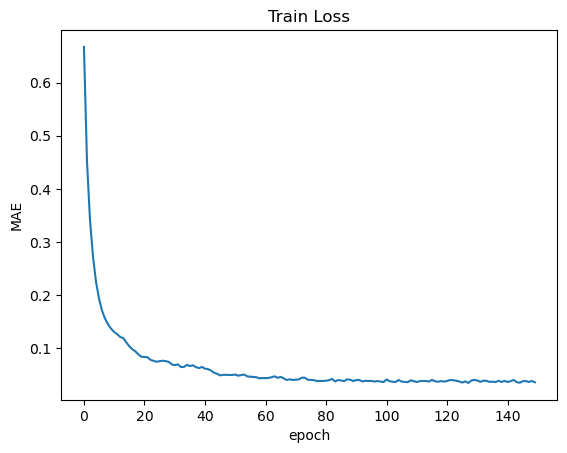

In [16]:
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('MAE')

In [17]:
model = AutoEncoder()
learning_rate = 1e-2
epochs = 300
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = nn.L1Loss()
model.load_state_dict(torch.load('checkpoint_AE/best_model.pth'))

<All keys matched successfully>

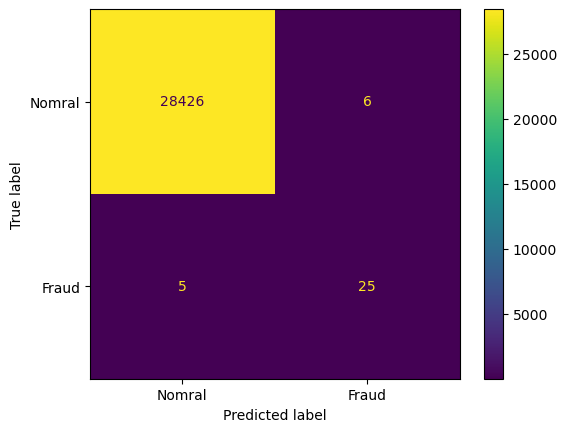

In [18]:
val_df_copy = val_df.drop('Class', axis=1)
opt = Optimization(model, optimizer, criterion, schedular, device, 0.95)
val_dataset2 = CustomDataset(val_df_copy, eval_mode=False)
val_loader2 = DataLoader(val_dataset2, batch_size, shuffle=False)
val_pred = opt.evaluate(val_loader2)
cm = confusion_matrix(val_df['Class'], val_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Fraud'])
disp.plot()

In [19]:
pred = opt.evaluate(test_loader)

In [20]:
answer = sample_submission
answer['Class'] = pred
answer.to_csv('submit_autoencoder_FI.csv', index=False)